# Lindblad Dissipation

To model dissipation in greater depth, GRANAD makes a Lindblad dissipation model available. The mathematical details are laid out in [Pelc et al., 2024](https://link.aps.org/doi/10.1103/PhysRevA.109.022237) and revolve around the following equation

$$\gamma_{ij}(t) = \gamma_{ij} \cdot f(t)$$

where $\gamma_{ij}$ is the transition rate from state i to state j and $f$ is a relaxation functional to prevent breaking the Pauli principle (pushing more than 2 electrons into the same energetic state).

## Lindblad Relaxation dynamics of the Metallic Chain

In the following, we will consider a metallic chain with a uniform transition rate.

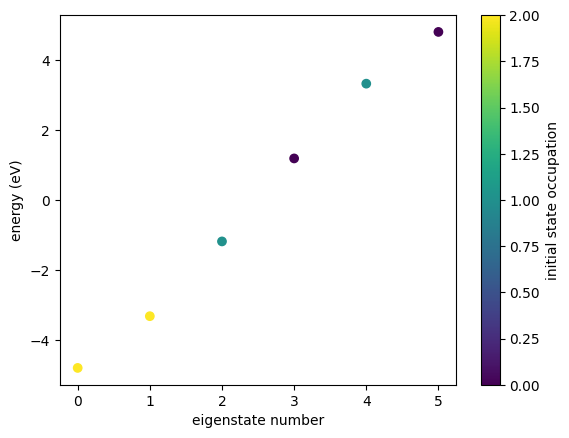

In [1]:
from granad import MaterialCatalog, Hexagon, Pulse

flake = MaterialCatalog.get("metal_1d").cut_flake( 6 )
flake.set_excitation(flake.homo, flake.homo+2, 1)
flake.show_energies()

We can now build the matrix of transitions rates with a uniform rate of $\gamma = 10$ as follows

In [2]:
delta = flake.energies[:,None] - flake.energies
gamma = 10.
gamma_matrix = gamma * (delta > 0)

We can inspect the lumo-homo transition rate, for example, as

In [3]:
print(gamma_matrix[flake.homo+1, flake.homo])

10.0


GRANAD dispatches the non-hermitian functional depending on the `relaxation_rate` input type. If you pass a float, GRANAD uses the decoherence approximation. If you pass an array, it uses the Lindblad dissipator with a (smooth approximation of) the Heaviside function as the saturation functional. We will talk about how to modify the relaxation functional shortly.

We now integrate the master equation.

RHS compiled
RHS compiled


100.0 %


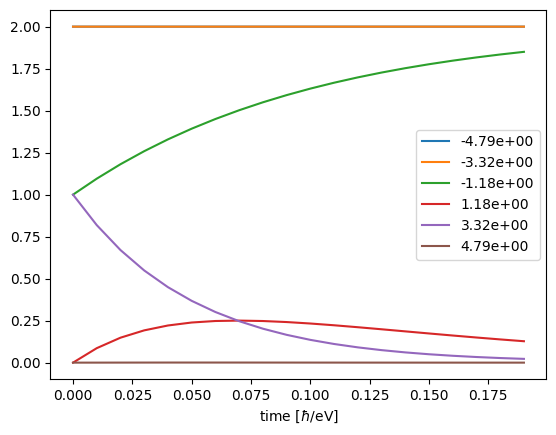

In [4]:
labels = [f"{e:.2e}" for e in flake.energies]
result = flake.master_equation(relaxation_rate = gamma_matrix,
                               end_time = 0.2,
                               density_matrix = ['occ_e'],
                               )
flake.show_res(result, show_illumination=False, plot_labels = labels)

Comparing this to the phenomenological approach

RHS compiled
RHS compiled


100.0 %


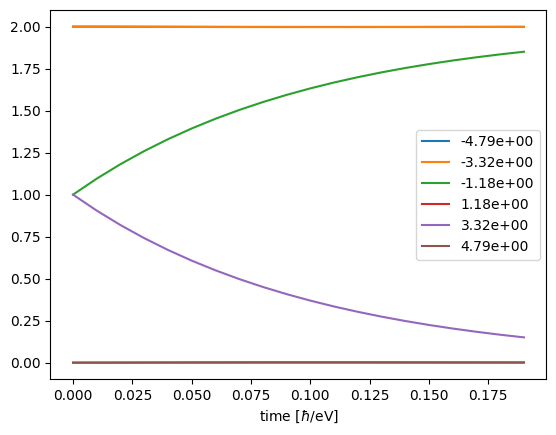

In [5]:
result = flake.master_equation(relaxation_rate = gamma,
                               end_time = 0.2,
                               density_matrix = ['occ_e'],
                               )
flake.show_res(result, show_illumination=False, plot_labels = labels)

GRANAD imposes a degeneracy tolerance on the states. This means that all states separated by less than a numerical threshold are considered degenerate. The threshold is specified as variable `flake.params.eps`.

## Modifying the saturation functional

The saturation functional can be customized by defining a saturation function and modifying the dissipator dict (for more information, please consult the tutorial on custom time evolution).

In short, you

1. initialize a dissipator with your custom relaxation functional
2. pass the gamma matrix as the relaxation rate as usual

We will study what happens if we completely turn off saturation 

RHS compiled
RHS compiled


100.0 %


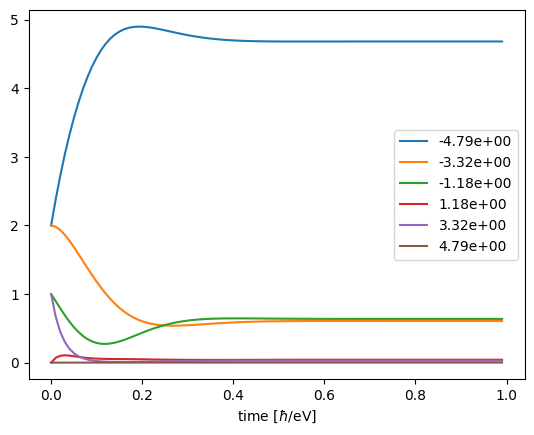

In [6]:
import jax.numpy as jnp
def no_saturation(x):
    return 1.

dissipator = flake.get_dissipator(saturation = no_saturation)

result = flake.master_equation(relaxation_rate = gamma_matrix,
                               dissipator = dissipator,
                               end_time = 1,
                               density_matrix = ['occ_e'],
                               )
flake.show_res(result, show_illumination=False, plot_labels = labels)

We observe an almost complete collapse into the IP ground state, prohibited only by what we can quickly check to be an interaction effect.

RHS compiled
RHS compiled


100.0 %


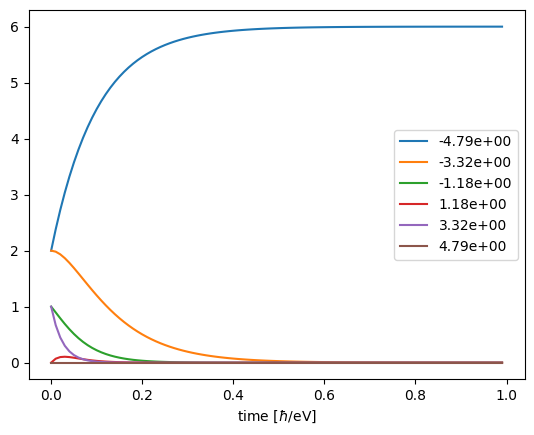

In [7]:
result = flake.master_equation(relaxation_rate = gamma_matrix,
                               dissipator = dissipator,
                               end_time = 1,
                               density_matrix = ['occ_e'],
                               coulomb_strength = 0. # turn off Coulomb interaction
                               )
flake.show_res(result, show_illumination=False, plot_labels = labels)

## Corrected Lindblad

A precursor of the saturated Linblad model replaces $D[\rho] \rightarrow D[\rho - \rho_0]$, i.e. it applies the Lindblad operators to $\rho - \rho_0$, much like the phenomenological dissipator.

It can be shown that this model for an $N$ electron system is equivalent to the phenomenological dissipator with relaxation rate $r$ if $\gamma^{ij} = \gamma = \frac{r}{N}$. We can check this is as follows

RHS compiled
RHS compiled


100.0 %


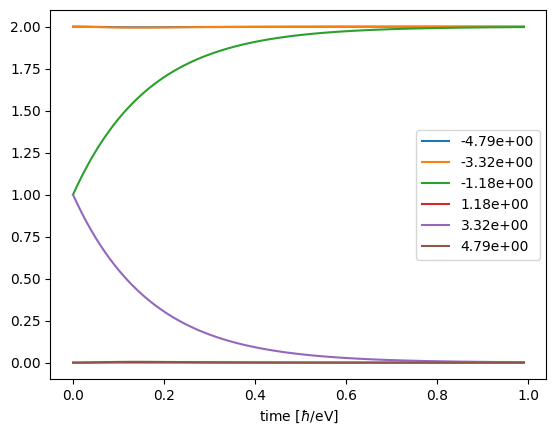

In [8]:
from granad import dissipators

gamma_matrix = jnp.ones_like(flake.hamiltonian)

dissipator = {"corrected":dissipators.CorrectedLindblad(no_saturation)}

result = flake.master_equation(relaxation_rate = gamma_matrix,
                               dissipator = dissipator,
                               end_time = 1,
                               density_matrix = ['occ_e'],
                               )
flake.show_res(result, show_illumination=False, plot_labels = labels)

We can now compare to the phenomenological dissipator with its rate scaled by $N$.

RHS compiled
RHS compiled


100.0 %


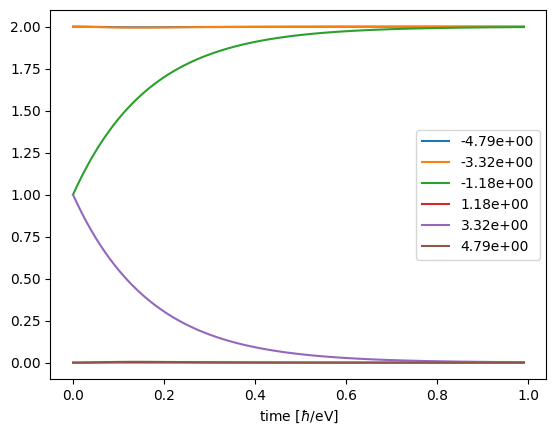

In [9]:
result = flake.master_equation(relaxation_rate = 6.,
                               end_time = 1,
                               density_matrix = ['occ_e'],
                               )
flake.show_res(result, show_illumination=False, plot_labels = labels)

## Wigner-Weisskopf transition rates

GRANAD also offers the IP wigner_weisskopf_transition_rates directly as a gamma matrix like

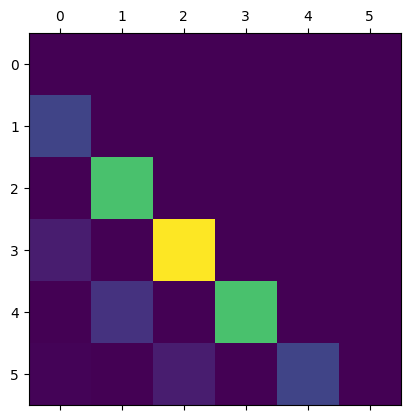

In [10]:
import matplotlib.pyplot as plt
gamma_matrix = flake.wigner_weisskopf_transition_rates
plt.matshow(gamma_matrix.real)
plt.show()

NOTE: things will likely break if you use these rates directly without rescaling them somehow. 